<a href="https://colab.research.google.com/github/FelipeH22/regularization-feature-selection/blob/main/regularization_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Selection Using L1 Regularization on Shallow Neural Networks for Glioma Grading from Molecular and Demographic Data

### Data preparation

In [ ]:
%%capture
!unzip glioma_ds.zip

In [ ]:
import copy
import random
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

In [ ]:
sns.set_theme()

In [ ]:
np.set_printoptions(precision=4)

First, the [data](https://archive.ics.uci.edu/dataset/759/glioma+grading+clinical+and+mutation+features+dataset) is read from the CSV file using the pandas function in order to store the result in a pandas dataframe. Then, the data is sorted randomly.

In [ ]:
df = pd.read_csv("TCGA_InfoWithGrade.csv").sample(frac=1)
df

,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,CIC,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
235,0,0,43.99,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
233,0,0,21.67,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
242,0,1,34.52,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
325,0,1,34.44,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
150,0,0,56.44,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,0,0,42.01,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
305,0,0,60.04,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
334,0,1,58.15,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
174,0,0,48.54,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def make_train_test_split(df, test_size=0.15):
  """
  Creates a copy of the dataframe sent as an argument in order to not modify the
  original one, then, the 'Grade' column is extracted for the labels, age column
  is standarized, the columns are shuffled and then a train_test_split is performed.
  """
  data = copy.deepcopy(df)
  labels = data["Grade"]
  del data["Grade"]
  if "Age_at_diagnosis" in data.columns:
    data["Age_at_diagnosis"] = StandardScaler().fit_transform(data["Age_at_diagnosis"].to_numpy().reshape(-1, 1)).reshape(len(data),)
  columns = data.columns.tolist()
  random.shuffle(columns)
  data = data[columns]
  print(data.head(3))
  X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=test_size)
  print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
  return X_train.reset_index(drop=True), X_test, y_train.reset_index(drop=True), y_test

In [ ]:
def make_model(print_model=True, inp_shape=23, name=None):
  """
  Creates a model using the Sequential tensorflow API with three layers:
  1. Dense, inp_shape number of units, this unit receives the input directly, L1 regularization.
  2. Dense, 15 units, relu activation, L1 regularization.
  3. Output dense layer, 1 unit, linear activation

  The model is compiled using Adam with its default lr, binary crossentropy loss
  using the from_logits parameter that puts the model output (as a function) directly into the
  loss function so no specific activation is needed in the output layer (the usage of
  this parameter is highly encouraged because it avoids precision errors).
  Accuracy metric monitoring is also added.
  """
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(inp_shape, input_shape=(None, inp_shape), kernel_regularizer=tf.keras.regularizers.L1()),
      tf.keras.layers.Dense(15, activation="relu", kernel_regularizer=tf.keras.regularizers.L1()),
      tf.keras.layers.Dense(1)
  ], name=name)
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["acc"])
  if print_model: model.summary()
  return model

In [ ]:
def train_model(model, X_train, y_train, **kwargs):
  """
  Trains the model received as an argument using X_train and y_train.
  Also, other parameters sent in kwargs are set in order to make this function
  reusable when more specific needs for training are mandatory. These parameters are:
  - batch_size: int, size of the batch.
  - epochs: int, number of epochs.
  - validation_split: float that determines the X_train portion used for validation.
  - verbose: int -> element in {0, 1, 2}.
  - callbacks: list of callbacks objects.
  """
  history = model.fit(X_train, y_train,
                      batch_size=16 if "batch_size" not in kwargs else kwargs["batch_size"],
                      epochs=500 if "epochs" not in kwargs else kwargs["epochs"],
                      validation_data=None if "validation_data" not in kwargs else kwargs["validation_data"],
                      validation_split=0.2 if "validation_split" not in kwargs else kwargs["validation_split"],
                      verbose=0 if "verbose" not in kwargs else kwargs["verbose"],
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15),
                                 tf.keras.callbacks.ModelCheckpoint("./models/", monitor="val_acc", save_best_only=True)
                                 ] if "callbacks" not in kwargs else kwargs["callbacks"]
                      )
  if "X_test" in kwargs and "y_test" in kwargs:
    print(model.evaluate(kwargs["X_test"], kwargs["y_test"], verbose=2))
  return model, history

In [ ]:
def plot_learning_curves(history_data, metrics:list=["loss", "acc"], with_validation=True, file_name=None):
  """
  Plots the learning curve with the data retrieved from history_data, a history
  object result of training a model. A subplot is created for each metric sent
  in the list argument 'metrics' and if 'with_validation' flag is set to True then
  for each subplot the same metric obtained in the validation dataset is shown in the plot.
  """
  def subplot(metric, figure):
    figure.plot(history_data.history[metric], label=f"training {metric}")
    figure.plot(history_data.history[f"val_{metric}"], label=f"validation {metric}")
    if isinstance(figure, matplotlib.axes._axes.Axes):
      figure.set_xlabel("Epochs")
      figure.set_ylabel(metric)
      figure.set_title(f"{metric} per epoch")
    else:
      figure.xlabel("Epochs")
      figure.ylabel(metric)
      figure.title(f"{metric} per epoch")
    figure.legend()
  if len(metrics)>1:
    fig, axes = plt.subplots(1, len(metrics), figsize=(12, 4))
    for i, ax in enumerate(axes):
      subplot(metrics[i], ax)
    fig.suptitle("")
  else:
    subplot(metrics[0], plt)
  if file_name: plt.savefig(file_name)
  plt.show()

In [ ]:
def evaluate_model(model, X_test, y_test, reshape=False, plot_confusion_matrix=False, print_all_results=True, confusion_file_name=None):
  """
  Returns the model performance measured by precision, recall, F1 and accuracy.
  Also, a confusion matrix is shown if 'plot_confusion_matrix' parameter is set
  to True. A reshape parameter is created in order to reshape the predictions
  for those models that have specific number of features.
  """
  predictions = tf.keras.activations.sigmoid(model.predict(X_test, verbose=0))
  predictions = np.round(predictions)
  if reshape: predictions = predictions.reshape(len(y_test),)
  pres = precision_score(y_test, predictions, zero_division=0)
  rec = recall_score(y_test, predictions, zero_division=0)
  f1 = f1_score(y_test, predictions, zero_division=0)
  acc = accuracy_score(y_test, predictions)
  auc = roc_auc_score(y_test, predictions)
  if print_all_results:
    print("Precision score: ", pres)
    print("Recall score: ", rec)
    print("F1 score: ", f1)
    print("Accuracy score: ", acc)
    print("ROC AUC: ", auc)
  if plot_confusion_matrix:
    sns.reset_orig()
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predictions))
    disp.plot()
    if confusion_file_name: plt.savefig(confusion_file_name)
    plt.show()
  return pres, rec, f1, acc, auc

# Regularization Feature Selection using Deep Learning

The following cell is added in order to create the splits between training (85%) and test (15%) datasets

In [ ]:
# Every time, this line yields in different columns order
X_train, X_test, y_train, y_test = make_train_test_split(df)

     Gender  PIK3R1  FUBP1  RB1  Race  PTEN  IDH1  IDH2  NOTCH1  NF1  ...  \
235       0       0      0    0     0     0     1     0       0    0  ...   
233       0       0      0    0     0     0     1     0       0    0  ...   
242       1       0      0    1     0     1     0     0       0    1  ...   

     GRIN2A  SMARCA4  PDGFRA  Age_at_diagnosis  BCOR  MUC16  CIC  CSMD3  EGFR  \
235       0        0       0         -0.442581     0      0    0      0     0   
233       0        0       0         -1.864873     0      0    0      0     0   
242       0        0       0         -1.046035     0      0    0      0     0   

     TP53  
235     0  
233     1  
242     0  

[3 rows x 23 columns]
X_train shape: (713, 23), X_test shape: (126, 23), y_train shape: (713,), y_test shape: (126,)


In [ ]:
def train_evaluate_k_fold(X, y, folds=10, **kwargs):
  """
  Performs K-Fold Cross-Validation with the data and a base model (a new model
  is used for each fold). Returns the best model and prints the average and best
  metrics.
  Since the dataset is not too big a tensorflow's input pipeline is not needed.
  """
  precisions = list()
  recalls = list()
  f1s = list()
  accs = list()
  aucs = list()
  histories = list(0 for _ in range(folds))
  models = list(make_model(print_model=True if i==0 else False, name=f"Fold-{i}", inp_shape=23 if "inp_shape" not in kwargs else kwargs["inp_shape"]) for i in range(folds))
  kfold = KFold(n_splits=folds, shuffle=True)
  current_fold = 0
  for train, validation in kfold.split(X, y):
    model_fold_i = models[current_fold]
    if "print_all_results" not in kwargs or ("print_all_results" in kwargs and kwargs["print_all_results"]):
      print(f"Fold {current_fold}:")
    models[current_fold], histories[current_fold] = train_model(model_fold_i,
                                                                X.iloc[train], y.iloc[train],
                                                                validation_data=(X.iloc[validation], y.iloc[validation]),
                                                                **kwargs)
    pres, rec, f1, acc, auc = evaluate_model(model_fold_i, X.iloc[validation],
                                             y.iloc[validation], reshape=False if "reshape" not in kwargs else kwargs["reshape"],
                                             print_all_results=True if "print_all_results" not in kwargs else kwargs["print_all_results"])
    precisions.append(pres)
    recalls.append(rec)
    f1s.append(f1)
    accs.append(acc)
    aucs.append(auc)
    if "print_all_results" not in kwargs or ("print_all_results" in kwargs and kwargs["print_all_results"]):
      print("_________________________________________________________________")
    current_fold+=1
  precisions = np.array(precisions)
  recalls = np.array(recalls)
  f1s = np.array(f1s)
  accs = np.array(accs)
  aucs = np.array(aucs)
  print(f"Average Precision: {np.mean(precisions)}, Average Recall: {np.mean(recalls)}, Average F1: {np.mean(f1s)}, Average Accuracy: {np.mean(accs)}, Average ROC AUC: {np.mean(aucs)}")
  best_model = np.argmax(accs)
  print(f"Best model: fold {best_model}. Precision: {precisions[best_model]}, Recall: {recalls[best_model]}, F1: {f1s[best_model]}, Accuracy: {accs[best_model]}, ROC AUC: {aucs[best_model]}")
  print("Best model learning plot:")
  plot_learning_curves(histories[best_model], file_name=None if "file_name" not in kwargs else kwargs["file_name"])
  return models[np.argmax(accs)]

Trains the general from whom the features importance will be extracted. The training is done through the function defined to perform K-Fold CV. The best model is then saved into the variable `best_model`.

The results for each fold is shown and the learning curves for the best model too.

Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 23)          552       
                                                                 
 dense_1 (Dense)             (None, None, 15)          360       
                                                                 
 dense_2 (Dense)             (None, None, 1)           16        
                                                                 
Total params: 928 (3.62 KB)
Trainable params: 928 (3.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Fold 0:
Precision score:  0.8846153846153846
Recall score:  0.8846153846153846
F1 score:  0.8846153846153846
Accuracy score:  0.9166666666666666
ROC AUC:  0.9096989966555185
_________________________________________________________________
Fold 1:
Precision score:  0.8157894736842105
Recall sc

Precision score:  0.7631578947368421
Recall score:  0.9354838709677419
F1 score:  0.8405797101449276
Accuracy score:  0.8450704225352113
ROC AUC:  0.855241935483871
_________________________________________________________________
Fold 5:


Precision score:  0.8611111111111112
Recall score:  0.9393939393939394
F1 score:  0.8985507246376813
Accuracy score:  0.9014084507042254
ROC AUC:  0.9039074960127592
_________________________________________________________________
Fold 6:
Precision score:  0.7714285714285715
Recall score:  0.8181818181818182
F1 score:  0.7941176470588236
Accuracy score:  0.8028169014084507
ROC AUC:  0.8038277511961723
_________________________________________________________________
Fold 7:
Precision score:  0.7105263157894737
Recall score:  0.9642857142857143
F1 score:  0.8181818181818182
Accuracy score:  0.8309859154929577
ROC AUC:  0.8542358803986712
_________________________________________________________________
Fold 8:
Precision score:  0.84375
Recall score:  0.9310344827586207
F1 score:  0.8852459016393444
Accuracy score:  0.9014084507042254
ROC AUC:  0.9059934318555007
_________________________________________________________________
Fold 9:
Precision score:  0.8064516129032258
Recall score: 

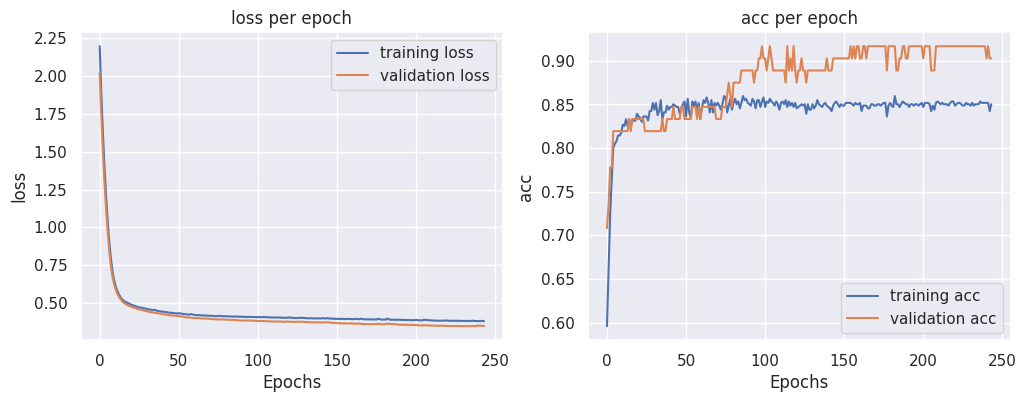

In [ ]:
best_model = train_evaluate_k_fold(X_train, y_train, folds=10,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)],
                                   file_name="regularization_model_training_curves.png")

Precision score:  0.8392857142857143
Recall score:  0.8867924528301887
F1 score:  0.8623853211009174
Accuracy score:  0.8809523809523809
ROC AUC:  0.881752390798656


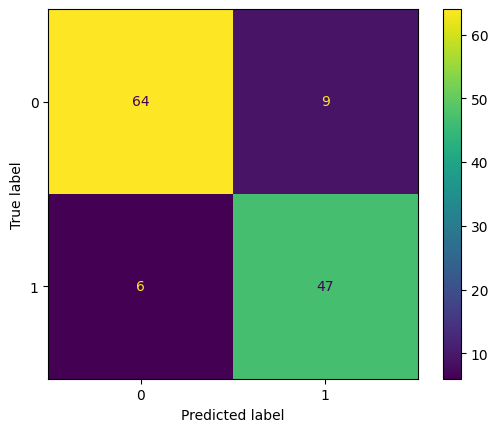

In [ ]:
# Model performance for test dataset
evaluate_model(best_model, X_test, y_test, plot_confusion_matrix=True, confusion_file_name="confusion_matrix_general.png");

## Weight extraction from the best model

The following cell extracts the weights from the first layer of the model in order to retrieve the importance for each feature

In [ ]:
weights = best_model.layers[0].get_weights()[0]
feature_importance = tf.reduce_sum(tf.abs(weights), axis=-1).numpy()
feature_importance

array([0.1411, 0.0577, 0.0283, 0.1082, 0.0031, 0.4123, 0.0047, 0.2903,
       0.021 , 0.0022, 0.1987, 0.1242, 0.0039, 0.0021, 0.0028, 0.8144,
       0.0304, 0.2106, 0.0025, 0.1116, 0.2237, 0.0037, 0.1786],
      dtype=float32)

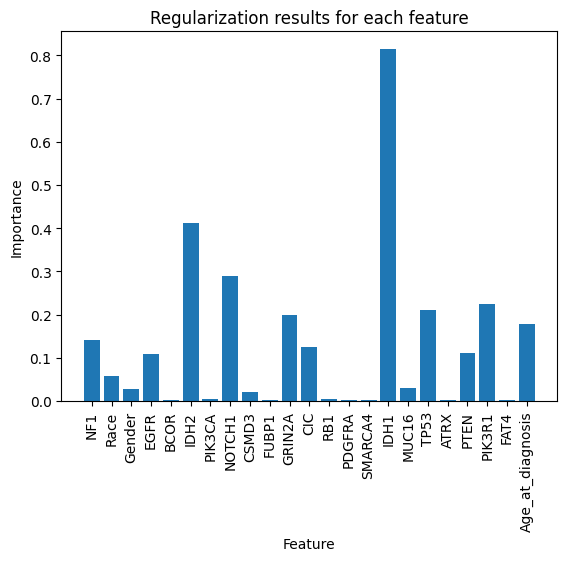

In [ ]:
names=X_train.columns
plt.bar(names, feature_importance)
plt.xticks(rotation=90)
plt.grid(False)
plt.title("Regularization results for each feature")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.savefig("regularization_features_hist.png")
plt.show()

Training 15 models, first one with the most important feature, the second one with the two most important features and so on. For each set of features, 10-Fold CV is applied.

Features: ['IDH1']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, None, 1)           2         
                                                                 
 dense_31 (Dense)            (None, None, 15)          30        
                                                                 
 dense_32 (Dense)            (None, None, 1)           16        
                                                                 
Total params: 48 (192.00 Byte)
Trainable params: 48 (192.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7548001051401255, Average Recall: 0.9355929267074903, Average F1: 0.8342976481284898, Average Accuracy: 0.8471830985915492, Average ROC AUC: 0.857032546814643
Best model: fold 6. Precision: 0.8611111111111112, Recall: 0.96875, F1: 0.911764705882353

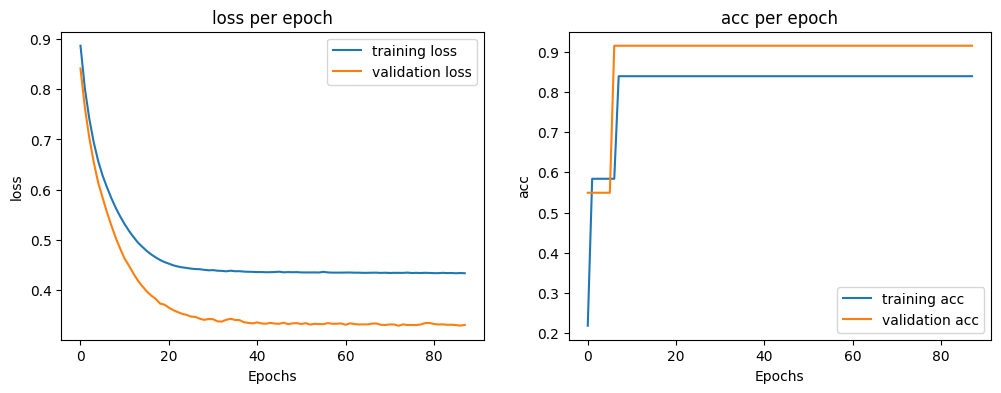

---------------------------------------------------------
Features: ['IDH2', 'IDH1']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_60 (Dense)            (None, None, 2)           6         
                                                                 
 dense_61 (Dense)            (None, None, 15)          45        
                                                                 
 dense_62 (Dense)            (None, None, 1)           16        
                                                                 
Total params: 67 (268.00 Byte)
Trainable params: 67 (268.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.792469973910414, Average Recall: 0.9333706005042212, Average F1: 0.8559057227985729, Average Accuracy: 0.8681338028169014, Average ROC AUC: 0.8774631788452412
Best model: fold 2. Pre

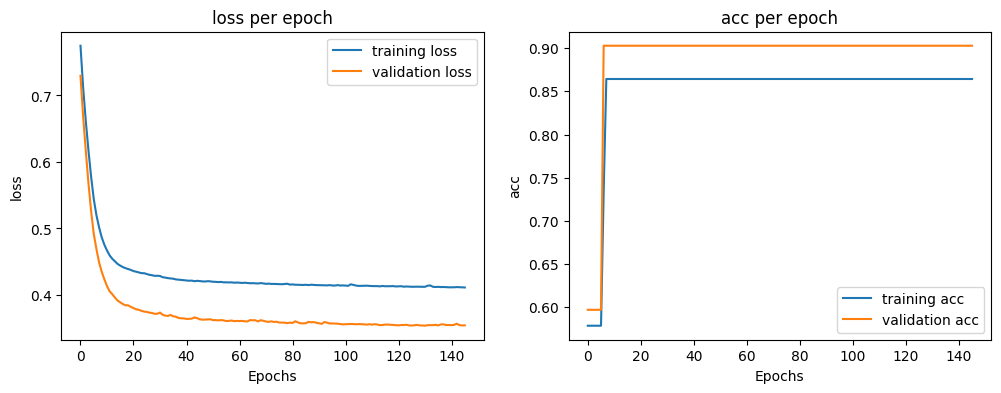

---------------------------------------------------------
Features: ['NOTCH1', 'IDH2', 'IDH1']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, None, 3)           12        
                                                                 
 dense_91 (Dense)            (None, None, 15)          60        
                                                                 
 dense_92 (Dense)            (None, None, 1)           16        
                                                                 
Total params: 88 (352.00 Byte)
Trainable params: 88 (352.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7930205128411728, Average Recall: 0.9326159111952966, Average F1: 0.8550023592109224, Average Accuracy: 0.8681338028169012, Average ROC AUC: 0.8772541727665871
Best model: 

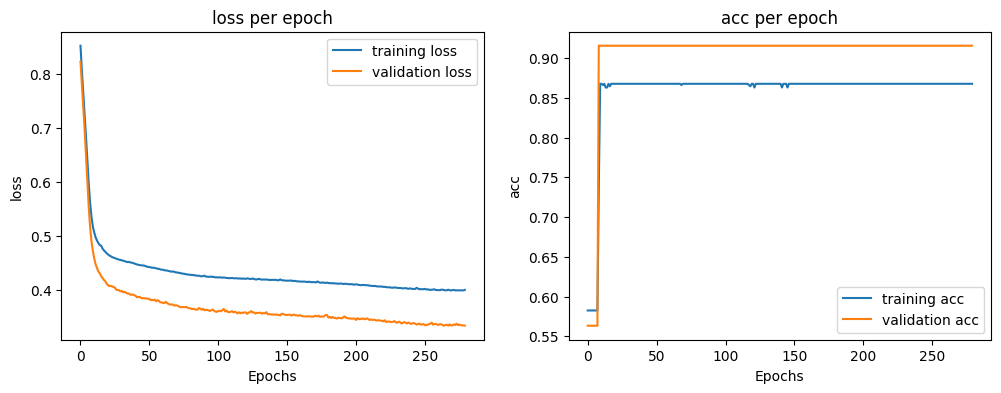

---------------------------------------------------------
Features: ['PIK3R1', 'NOTCH1', 'IDH2', 'IDH1']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, None, 4)           20        
                                                                 
 dense_121 (Dense)           (None, None, 15)          75        
                                                                 
 dense_122 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 111 (444.00 Byte)
Trainable params: 111 (444.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7888065266487505, Average Recall: 0.9303019049915603, Average F1: 0.8509870782412845, Average Accuracy: 0.8695031298904539, Average ROC AUC: 0.8786882012990553


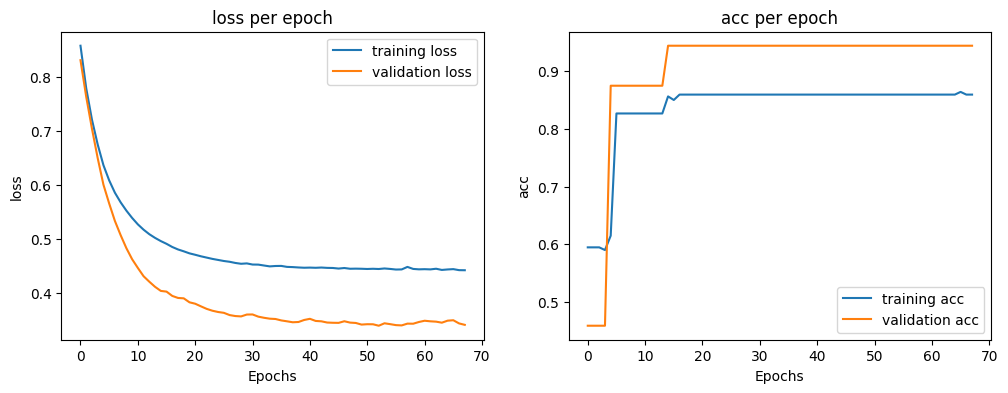

---------------------------------------------------------
Features: ['TP53', 'PIK3R1', 'NOTCH1', 'IDH2', 'IDH1']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, None, 5)           30        
                                                                 
 dense_151 (Dense)           (None, None, 15)          90        
                                                                 
 dense_152 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 136 (544.00 Byte)
Trainable params: 136 (544.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7882902234637494, Average Recall: 0.9326953828289218, Average F1: 0.8525193108385253, Average Accuracy: 0.8682316118935838, Average ROC AUC: 0.877780461

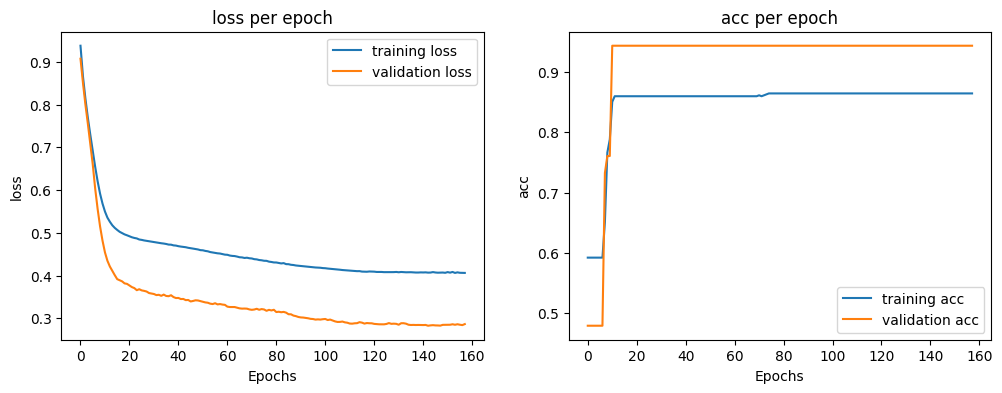

---------------------------------------------------------
Features: ['GRIN2A', 'TP53', 'PIK3R1', 'NOTCH1', 'IDH2', 'IDH1']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, None, 6)           42        
                                                                 
 dense_181 (Dense)           (None, None, 15)          105       
                                                                 
 dense_182 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 163 (652.00 Byte)
Trainable params: 163 (652.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7880722794069028, Average Recall: 0.9369953225142978, Average F1: 0.8549597601913218, Average Accuracy: 0.8710680751173708, Average ROC AUC: 0

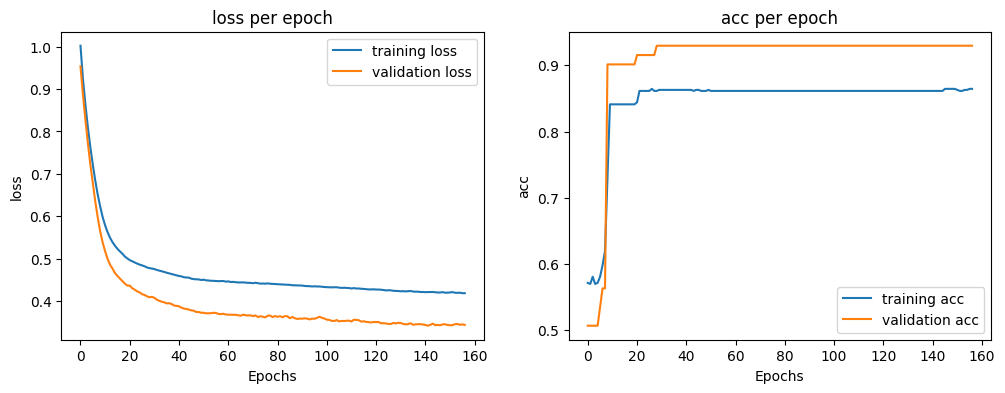

---------------------------------------------------------
Features: ['Age_at_diagnosis', 'GRIN2A', 'TP53', 'PIK3R1', 'NOTCH1', 'IDH2', 'IDH1']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_210 (Dense)           (None, None, 7)           56        
                                                                 
 dense_211 (Dense)           (None, None, 15)          120       
                                                                 
 dense_212 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 192 (768.00 Byte)
Trainable params: 192 (768.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7857088580997499, Average Recall: 0.9221757615807237, Average F1: 0.8468374179644282, Average Accuracy: 0.8625782472613459

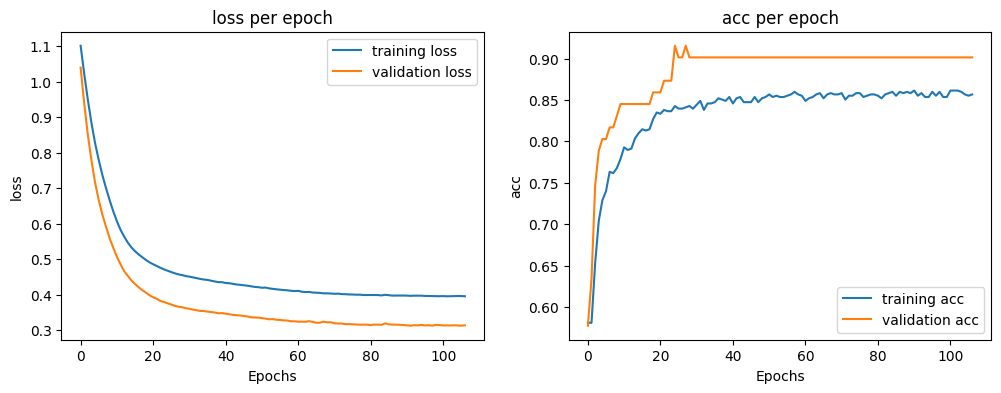

---------------------------------------------------------
Features: ['NF1', 'IDH1', 'TP53', 'GRIN2A', 'NOTCH1', 'PIK3R1', 'IDH2', 'Age_at_diagnosis']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, None, 8)           72        
                                                                 
 dense_241 (Dense)           (None, None, 15)          135       
                                                                 
 dense_242 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 223 (892.00 Byte)
Trainable params: 223 (892.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.8015205993236382, Average Recall: 0.9149700665482088, Average F1: 0.8505319627659995, Average Accuracy: 0.866705790

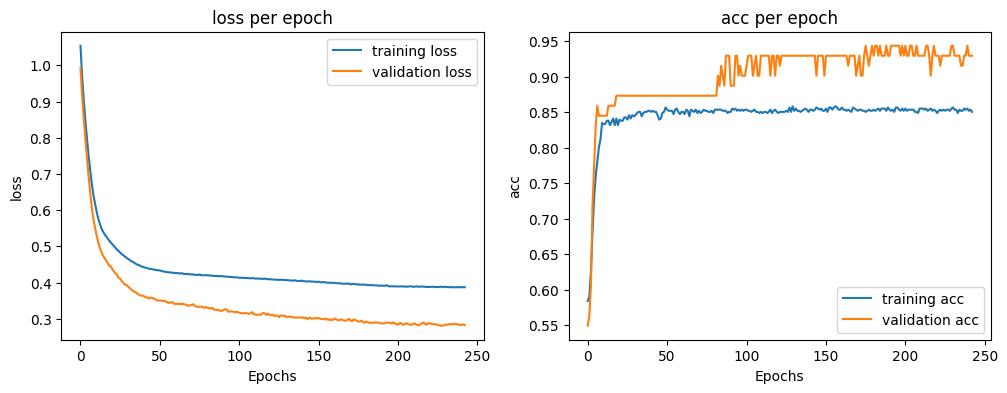

---------------------------------------------------------
Features: ['CIC', 'NF1', 'IDH1', 'TP53', 'GRIN2A', 'NOTCH1', 'PIK3R1', 'IDH2', 'Age_at_diagnosis']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_270 (Dense)           (None, None, 9)           90        
                                                                 
 dense_271 (Dense)           (None, None, 15)          150       
                                                                 
 dense_272 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 256 (1.00 KB)
Trainable params: 256 (1.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7961222979071543, Average Recall: 0.9221724470979682, Average F1: 0.8529750722383964, Average Accuracy: 0.8681533646

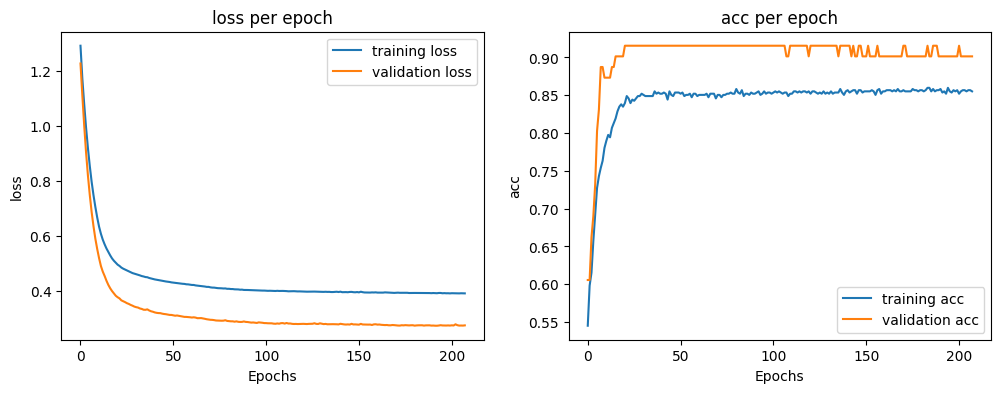

---------------------------------------------------------
Features: ['PTEN', 'CIC', 'NF1', 'IDH1', 'TP53', 'GRIN2A', 'NOTCH1', 'PIK3R1', 'IDH2', 'Age_at_diagnosis']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_300 (Dense)           (None, None, 10)          110       
                                                                 
 dense_301 (Dense)           (None, None, 15)          165       
                                                                 
 dense_302 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 291 (1.14 KB)
Trainable params: 291 (1.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7945241956914283, Average Recall: 0.9191941000966144, Average F1: 0.850844096467959, Average Accuracy: 0.865

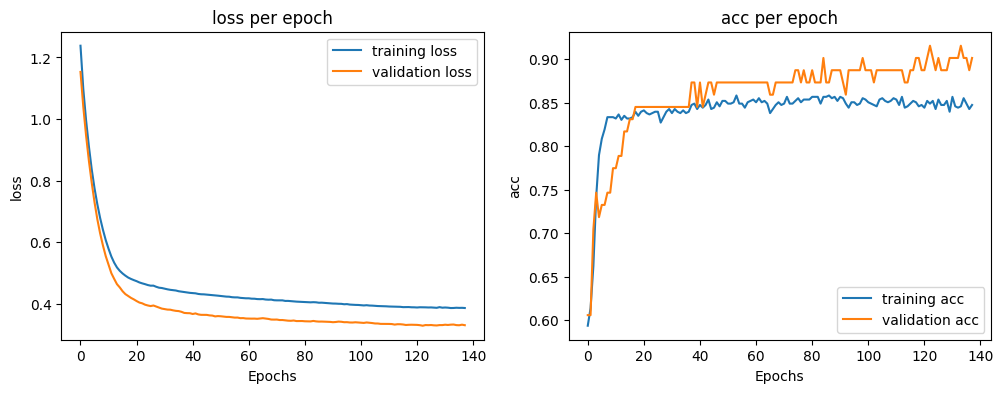

---------------------------------------------------------
Features: ['EGFR', 'PTEN', 'CIC', 'NF1', 'IDH1', 'TP53', 'GRIN2A', 'NOTCH1', 'PIK3R1', 'IDH2', 'Age_at_diagnosis']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_330 (Dense)           (None, None, 11)          132       
                                                                 
 dense_331 (Dense)           (None, None, 15)          180       
                                                                 
 dense_332 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 328 (1.28 KB)
Trainable params: 328 (1.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.8036137205088819, Average Recall: 0.9188691281542898, Average F1: 0.8556702910296423, Average Accura

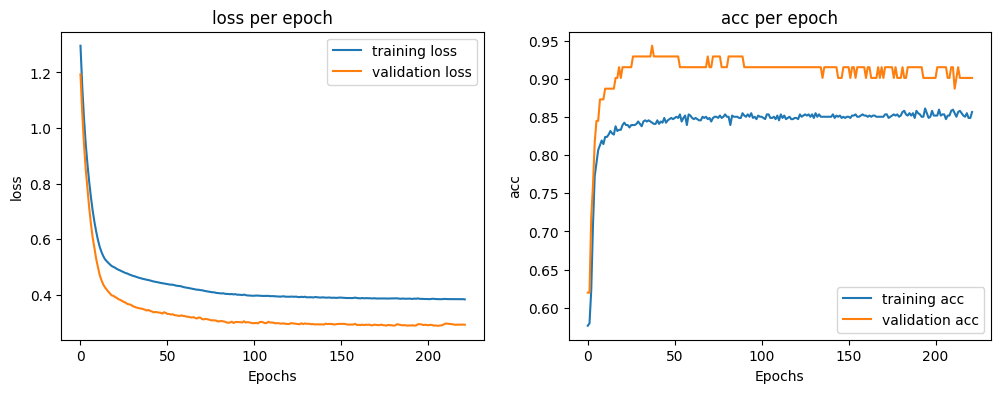

---------------------------------------------------------
Features: ['Race', 'EGFR', 'PTEN', 'CIC', 'NF1', 'IDH1', 'TP53', 'GRIN2A', 'NOTCH1', 'PIK3R1', 'IDH2', 'Age_at_diagnosis']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_360 (Dense)           (None, None, 12)          156       
                                                                 
 dense_361 (Dense)           (None, None, 15)          195       
                                                                 
 dense_362 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 367 (1.43 KB)
Trainable params: 367 (1.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7938611494265653, Average Recall: 0.9245082877026229, Average F1: 0.8516059904313711, Averag

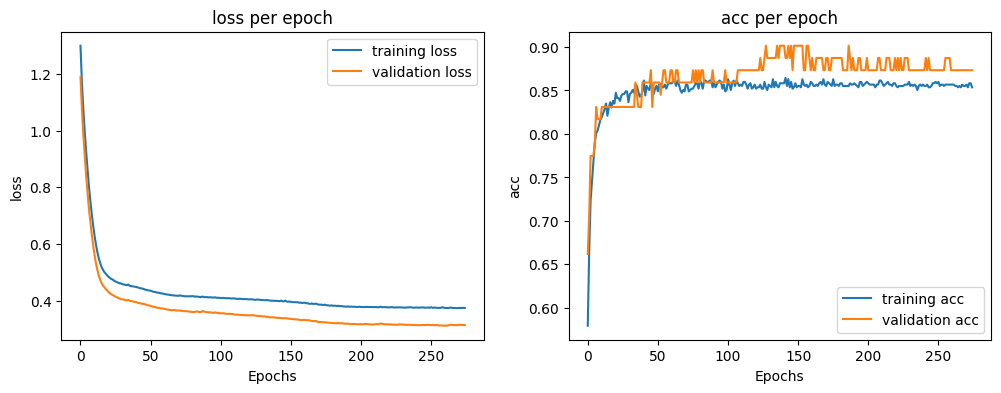

---------------------------------------------------------
Features: ['MUC16', 'Race', 'CIC', 'EGFR', 'PTEN', 'NF1', 'IDH1', 'TP53', 'GRIN2A', 'NOTCH1', 'PIK3R1', 'IDH2', 'Age_at_diagnosis']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_390 (Dense)           (None, None, 13)          182       
                                                                 
 dense_391 (Dense)           (None, None, 15)          210       
                                                                 
 dense_392 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 408 (1.59 KB)
Trainable params: 408 (1.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7930343769225615, Average Recall: 0.9201420585932649, Average F1: 0.848824240976048

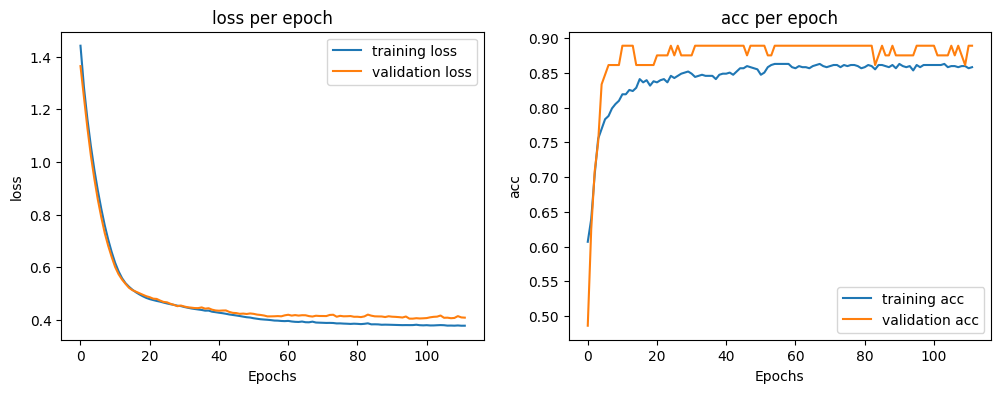

---------------------------------------------------------
Features: ['Gender', 'MUC16', 'Race', 'CIC', 'EGFR', 'PTEN', 'NF1', 'IDH1', 'TP53', 'GRIN2A', 'NOTCH1', 'PIK3R1', 'IDH2', 'Age_at_diagnosis']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_420 (Dense)           (None, None, 14)          210       
                                                                 
 dense_421 (Dense)           (None, None, 15)          225       
                                                                 
 dense_422 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 451 (1.76 KB)
Trainable params: 451 (1.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7947123345652758, Average Recall: 0.9217198625026768, Average F1: 0.85185

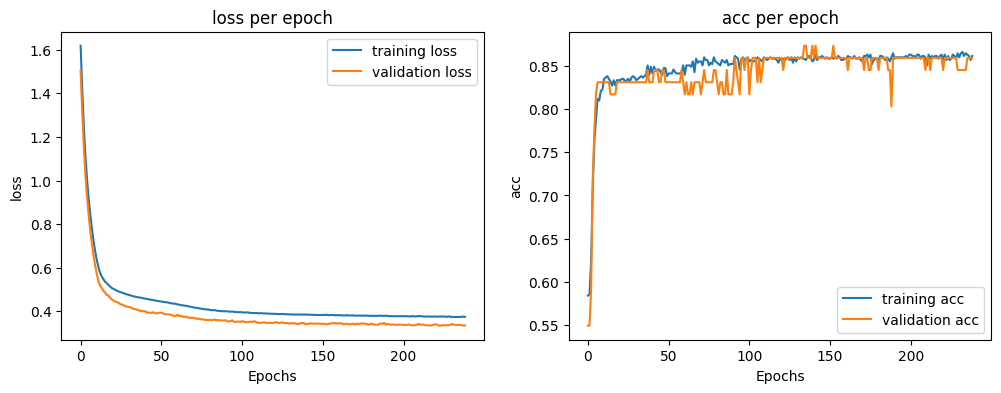

---------------------------------------------------------
Features: ['CSMD3', 'Gender', 'MUC16', 'Race', 'CIC', 'EGFR', 'PTEN', 'NF1', 'IDH1', 'TP53', 'GRIN2A', 'NOTCH1', 'PIK3R1', 'IDH2', 'Age_at_diagnosis']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_450 (Dense)           (None, None, 15)          240       
                                                                 
 dense_451 (Dense)           (None, None, 15)          240       
                                                                 
 dense_452 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 496 (1.94 KB)
Trainable params: 496 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7933608224049401, Average Recall: 0.913903705469334, Average F1:

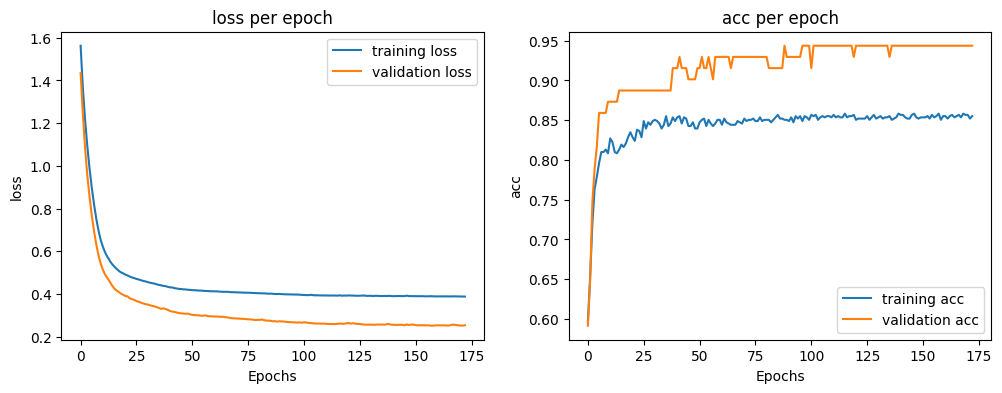

---------------------------------------------------------


In [ ]:
accuracies = list()
losses = list()
precisions = list()
recalls = list()
f1s = list()
aucs = list()
features_names = list()
for i in range(1, 16):
  number_of_features_to_use = i
  best_features = np.argpartition(feature_importance, -number_of_features_to_use)[-number_of_features_to_use:]
  new_x = X_train.iloc[:, best_features]
  features_names.append(new_x.columns.to_list())
  print(f"Features: {new_x.columns.to_list()}")
  best_model_ = train_evaluate_k_fold(new_x, y_train, folds=10,
                                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)],
                                      inp_shape=number_of_features_to_use, reshape=True,
                                      print_all_results=False,
                                      file_name=f"regularization_{new_x.columns.to_list()}_learning_curves.png")
  precision, recall, f1, _, auc = evaluate_model(best_model_, X_test.iloc[:, best_features], y_test, True, print_all_results=False)
  evaluation = best_model_.evaluate(X_test.iloc[:, best_features], y_test, verbose=0)
  accuracies.append(evaluation[1])
  precisions.append(precision)
  recalls.append(recall)
  f1s.append(f1)
  aucs.append(auc)
  losses.append(evaluation[0])
  print("---------------------------------------------------------")

In [ ]:
results = {
    "number_of_features": range(1, 16),
    "features": features_names,
    "loss": losses,
    "accuracy": accuracies,
    "precision": precisions,
    "recall": recalls,
    "f1": f1s,
    "ROC AUC": aucs
}

The cell below saves the metrics obtained for each of the models trained with their corresponding features subset in a pandas dataframe that then gets exported as a CSV file.

In [ ]:
results_ds = pd.DataFrame.from_dict(results)
results_ds

,number_of_features,features,loss,accuracy,precision,recall,f1,ROC AUC
0,1,[IDH1],0.447846,0.841270,0.761905,0.905660,0.827586,0.850090
1,2,"[IDH2, IDH1]",0.417488,0.873016,0.813559,0.905660,0.857143,0.877488
2,3,"[NOTCH1, IDH2, IDH1]",0.408402,0.873016,0.813559,0.905660,0.857143,0.877488
3,4,"[PIK3R1, NOTCH1, IDH2, IDH1]",0.451678,0.873016,0.813559,0.905660,0.857143,0.877488
4,5,"[TP53, PIK3R1, NOTCH1, IDH2, IDH1]",0.416806,0.873016,0.813559,0.905660,0.857143,0.877488
5,6,"[GRIN2A, TP53, PIK3R1, NOTCH1, IDH2, IDH1]",0.431291,0.873016,0.813559,0.905660,0.857143,0.877488
6,7,"[Age_at_diagnosis, GRIN2A, TP53, PIK3R1, NOTCH...",0.412746,0.873016,0.842105,0.905660,0.872727,0.891186
7,8,"[NF1, IDH1, TP53, GRIN2A, NOTCH1, PIK3R1, IDH2...",0.407752,0.880952,0.854545,0.886792,0.870370,0.888602
8,9,"[CIC, NF1, IDH1, TP53, GRIN2A, NOTCH1, PIK3R1,...",0.406516,0.873016,0.857143,0.905660,0.880734,0.898036
9,10,"[PTEN, CIC, NF1, IDH1, TP53, GRIN2A, NOTCH1, P...",0.409154,0.880952,0.836364,0.867925,0.851852,0.872318


In [ ]:
results_ds.to_csv("metrics.csv")

A plot is made in order to show how the metrics behave when incrementing the number of features used

In [ ]:
fig = px.line(results, x="number_of_features",
              y=["recall", "accuracy",  "f1", "precision", "ROC AUC"], labels={
                  "number_of_features": "Number of Features",
                  "value": "Value",
                  "variable": "Metrics"
              }, title="Metrics by Feature")
fig.show()

In [ ]:
fig = px.line(results, x="number_of_features",
              y="loss", labels={
                  "number_of_features": "Number of Features",
                  "loss": "Loss"
              }, title="Loss by Number of Features")
fig.show()

### Other FS methods

This section contains the experimentation process for the other methods in order to perform the comparison with the regularization method. It contains the following three techniques
1.   LASSO using scikit-learn's Lasso regression
2.   minimum redundancy maximum relevance (mRMR)
3.   GradWise (method proposed by the authors of the dataset)

For each method, the same metrics are retrieved for 15 features just like in the regularization method.



LASSO

In [ ]:
import matplotlib
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold

Perform LASSO training using 10-Fold CV and changing the alpha parameter between 0.0001 and 10 for each fold.

In [ ]:
kf = KFold(n_splits=10, shuffle=True)
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, param_grid={"alpha":np.linspace(0.0001, 10, 10)},
                        cv=kf)
lasso_cv.fit(X_train, y_train)
best_estimat = lasso_cv.best_estimator_
best_estimat_coef = np.abs(best_estimat.coef_)

Once the training process is done, the coefficients of the best model are extracted and contrasted with the features that the model received as an input. The results are shown in a histogram

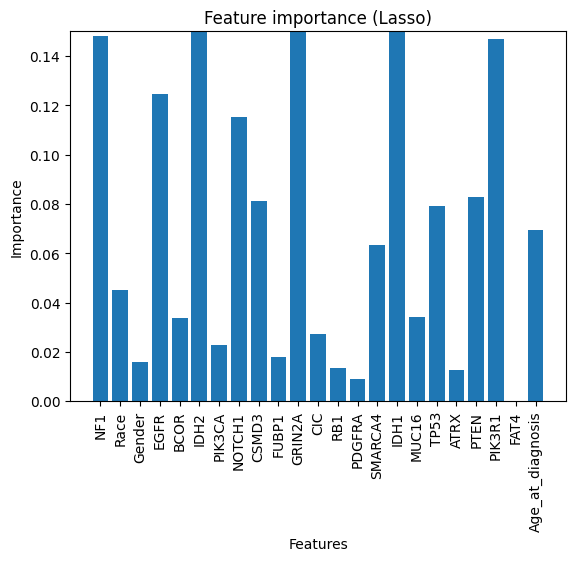

In [ ]:
names=X_train.columns
plt.bar(names, best_estimat_coef)
plt.xticks(rotation=90)
plt.grid(False)
plt.title("Feature importance (Lasso)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.ylim(0, 0.15)
plt.savefig("lasso_features_hist.png")
plt.show()

The cells below show the 15 most important features

In [ ]:
sorted_indices = np.argsort(best_estimat_coef)[::-1]
feature_subset=np.array(names)[best_estimat_coef>-1]
feature_subset = feature_subset[sorted_indices]
feature_subset = feature_subset[:15]
print(f"Selected Feature Columns: {feature_subset}")

feature_subset=np.append(feature_subset, "Grade")
print(f"Selected Columns: {feature_subset}")

Selected Feature Columns: ['IDH1' 'IDH2' 'GRIN2A' 'NF1' 'PIK3R1' 'EGFR' 'NOTCH1' 'PTEN' 'CSMD3'
 'TP53' 'Age_at_diagnosis' 'SMARCA4' 'Race' 'MUC16' 'BCOR']
Selected Columns: ['IDH1' 'IDH2' 'GRIN2A' 'NF1' 'PIK3R1' 'EGFR' 'NOTCH1' 'PTEN' 'CSMD3'
 'TP53' 'Age_at_diagnosis' 'SMARCA4' 'Race' 'MUC16' 'BCOR' 'Grade']


In [ ]:
df_new = df[feature_subset]
df_new

,IDH1,IDH2,GRIN2A,NF1,PIK3R1,EGFR,NOTCH1,PTEN,CSMD3,TP53,Age_at_diagnosis,SMARCA4,Race,MUC16,BCOR,Grade
175,1,0,0,0,0,0,0,0,0,1,29.22,0,0,0,0,0
755,0,0,0,0,0,1,0,0,0,0,75.21,0,1,1,0,1
385,1,0,0,0,1,0,0,0,0,0,56.87,0,0,1,0,0
804,0,0,0,0,0,0,0,0,0,0,79.50,0,1,0,0,1
106,1,0,0,0,1,0,0,0,0,1,41.21,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,0,0,1,0,0,0,0,0,0,1,70.32,0,0,0,0,1
152,1,0,0,0,0,0,0,0,0,1,60.18,0,0,0,0,0
421,0,0,0,0,0,1,0,1,0,0,51.33,0,0,0,0,0
776,0,0,0,1,0,0,0,0,0,0,81.06,0,0,0,0,1


In [ ]:
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = make_train_test_split(df_new);

     Age_at_diagnosis  NOTCH1  EGFR  PIK3R1  SMARCA4  Race  GRIN2A  IDH1  \
175         -1.383766       0     0       0        0     0       0     1   
755          1.546844       0     1       0        0     1       0     0   
385          0.378168       0     0       1        0     0       0     1   

     IDH2  TP53  NF1  MUC16  BCOR  CSMD3  PTEN  
175     0     1    0      0     0      0     0  
755     0     0    0      1     0      0     0  
385     0     0    0      1     0      0     0  
X_train shape: (713, 15), X_test shape: (126, 15), y_train shape: (713,), y_test shape: (126,)


A new neural network model is trained with the feature set retrieved from the selection process (the cell above shows the three first elements of the data)

Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_480 (Dense)           (None, None, 15)          240       
                                                                 
 dense_481 (Dense)           (None, None, 15)          240       
                                                                 
 dense_482 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 496 (1.94 KB)
Trainable params: 496 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Fold 0:
Precision score:  0.8518518518518519
Recall score:  0.9583333333333334
F1 score:  0.9019607843137256
Accuracy score:  0.9305555555555556
ROC AUC:  0.9375000000000001
_________________________________________________________________
Fold 1:
Precision score:  0.84375
Recall score:  0.931

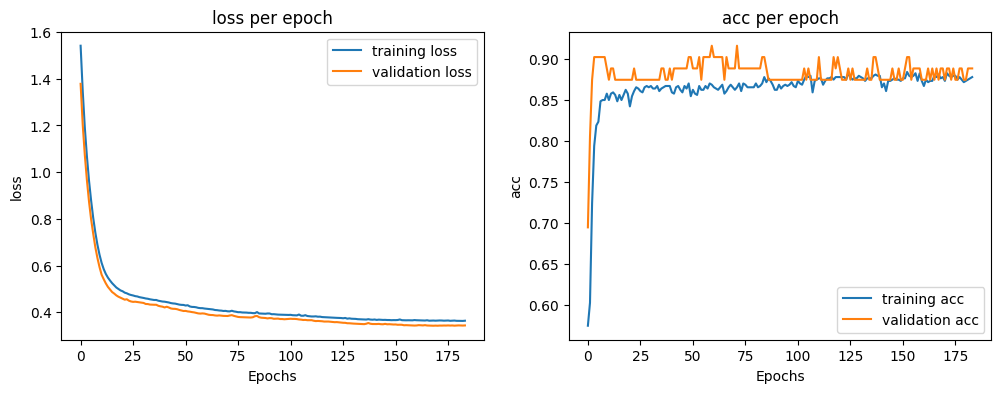

In [ ]:
lasso_model = train_evaluate_k_fold(X_train_lasso, y_train_lasso, folds=10,
                                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)],
                                    inp_shape=X_train_lasso.shape[-1],
                                    reshape=True,
                                    file_name="lasso_learning_curves.png")

A confusion matrix is then built for evaluating the model performance on the test dataset

Precision score:  0.71875
Recall score:  0.9019607843137255
F1 score:  0.8
Accuracy score:  0.8174603174603174
ROC AUC:  0.8309803921568627


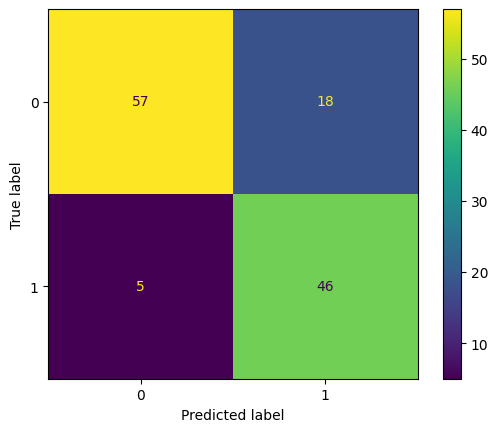

In [ ]:
evaluate_model(lasso_model, X_test_lasso, y_test_lasso, True, True, confusion_file_name="lasso_confusion.png");

Minimum Redundancy Maximum Relevance (mRMR)

In [ ]:
%%capture
!pip install pymrmr

In [ ]:
from pymrmr import mRMR

In order to perform the mRMR feature selection, the pymrmr library is used and using K-Fold, for each fold the 15 most important features of the training split for that fold are retrieved using the library and stored in an array.

Once the K-Fold process finishes, the ocurrence of each feature is counted and the features are sorted according to their ocurrence number. The top 15 features are chosen as the feature set retrieved by the mRMR method.

In [ ]:
# K-Fold for mRMR (no model trained)
kfold = KFold(n_splits=10, shuffle=True)
current_fold = 0
names = X_train.columns
features_set = list()
for train, validation in kfold.split(X_train, y_train):
  mrmr_fold_i = mRMR(X_train.iloc[train], "MID", 15)
  print(f"Features for fold {current_fold}: {mrmr_fold_i}")
  features_set = [*features_set, *mrmr_fold_i]
  current_fold+=1

unique_features, counts = np.unique(features_set, return_counts=True)
print(unique_features, counts)
sorted_indices = np.argsort(-counts)
sorted_elements = unique_features[sorted_indices]
sorted_counts = counts[sorted_indices]
top_15_features = list(sorted_elements[:15])
print(f"Final set of features: {top_15_features}")

Features for fold 0: ['Age_at_diagnosis', 'PIK3R1', 'BCOR', 'CSMD3', 'NF1', 'IDH2', 'FAT4', 'NOTCH1', 'PIK3CA', 'MUC16', 'Race', 'PTEN', 'PDGFRA', 'SMARCA4', 'GRIN2A']
Features for fold 1: ['Age_at_diagnosis', 'FAT4', 'BCOR', 'PIK3R1', 'CSMD3', 'IDH2', 'NOTCH1', 'GRIN2A', 'Race', 'PIK3CA', 'MUC16', 'NF1', 'SMARCA4', 'RB1', 'PDGFRA']
Features for fold 2: ['Age_at_diagnosis', 'BCOR', 'PIK3R1', 'CSMD3', 'IDH2', 'Race', 'NF1', 'MUC16', 'PIK3CA', 'FAT4', 'NOTCH1', 'SMARCA4', 'GRIN2A', 'PDGFRA', 'RB1']
Features for fold 3: ['Age_at_diagnosis', 'FAT4', 'IDH2', 'SMARCA4', 'PIK3R1', 'NF1', 'BCOR', 'Race', 'PDGFRA', 'CSMD3', 'NOTCH1', 'PIK3CA', 'RB1', 'MUC16', 'CIC']
Features for fold 4: ['Age_at_diagnosis', 'PIK3R1', 'BCOR', 'CSMD3', 'IDH2', 'GRIN2A', 'Race', 'PIK3CA', 'SMARCA4', 'NF1', 'PDGFRA', 'CIC', 'FAT4', 'MUC16', 'RB1']
Features for fold 5: ['Age_at_diagnosis', 'PIK3R1', 'CSMD3', 'BCOR', 'NF1', 'FAT4', 'IDH2', 'Race', 'GRIN2A', 'PIK3CA', 'SMARCA4', 'PDGFRA', 'RB1', 'CIC', 'MUC16']
Featur

In [ ]:
top_15_features.append("Grade")
df_new = df[top_15_features]
df_new

,Age_at_diagnosis,PIK3R1,PIK3CA,PDGFRA,NF1,IDH2,MUC16,FAT4,CSMD3,BCOR,SMARCA4,Race,RB1,NOTCH1,GRIN2A,Grade
235,43.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
233,21.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
242,34.52,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
325,34.44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
150,56.44,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,42.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
305,60.04,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
334,58.15,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
174,48.54,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train_mrmr, X_test_mrmr, y_train_mrmr, y_test_mrmr = make_train_test_split(df_new);

     NOTCH1  RB1  FAT4  PIK3CA  BCOR  MUC16  PDGFRA  PIK3R1  CSMD3  GRIN2A  \
235       0    0     0       0     0      0       0       0      0       0   
233       0    0     0       0     0      0       0       0      0       0   
242       0    1     0       0     0      0       0       0      0       0   

     Race  SMARCA4  IDH2  Age_at_diagnosis  NF1  
235     0        0     0         -0.442581    0  
233     0        0     0         -1.864873    0  
242     0        0     0         -1.046035    1  
X_train shape: (713, 15), X_test shape: (126, 15), y_train shape: (713,), y_test shape: (126,)


Another neural network is trained in order to try the new set of features, the metrics and confusion matrix are shown as well.

Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 15)          240       
                                                                 
 dense_1 (Dense)             (None, None, 15)          240       
                                                                 
 dense_2 (Dense)             (None, None, 1)           16        
                                                                 
Total params: 496 (1.94 KB)
Trainable params: 496 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Fold 0:
Precision score:  0.5769230769230769
Recall score:  0.5769230769230769
F1 score:  0.5769230769230769
Accuracy score:  0.6944444444444444
ROC AUC:  0.6688963210702341
_________________________________________________________________
Fold 1:
Precision score:  0.5517241379310345
Recall sc

Precision score:  0.8125
Recall score:  0.8125
F1 score:  0.8125
Accuracy score:  0.8309859154929577
ROC AUC:  0.829326923076923
_________________________________________________________________
Fold 5:


Precision score:  0.72
Recall score:  0.6428571428571429
F1 score:  0.6792452830188679
Accuracy score:  0.7605633802816901
ROC AUC:  0.7400332225913621
_________________________________________________________________
Fold 6:
Precision score:  0.75
Recall score:  0.6
F1 score:  0.6666666666666665
Accuracy score:  0.704225352112676
ROC AUC:  0.7027777777777778
_________________________________________________________________
Fold 7:
Precision score:  0.7307692307692307
Recall score:  0.59375
F1 score:  0.6551724137931033
Accuracy score:  0.7183098591549296
ROC AUC:  0.7071314102564102
_________________________________________________________________
Fold 8:
Precision score:  0.7692307692307693
Recall score:  0.6451612903225806
F1 score:  0.7017543859649122
Accuracy score:  0.7605633802816901
ROC AUC:  0.7475806451612902
_________________________________________________________________
Fold 9:
Precision score:  0.6
Recall score:  0.5769230769230769
F1 score:  0.5882352941176471
Accuracy 

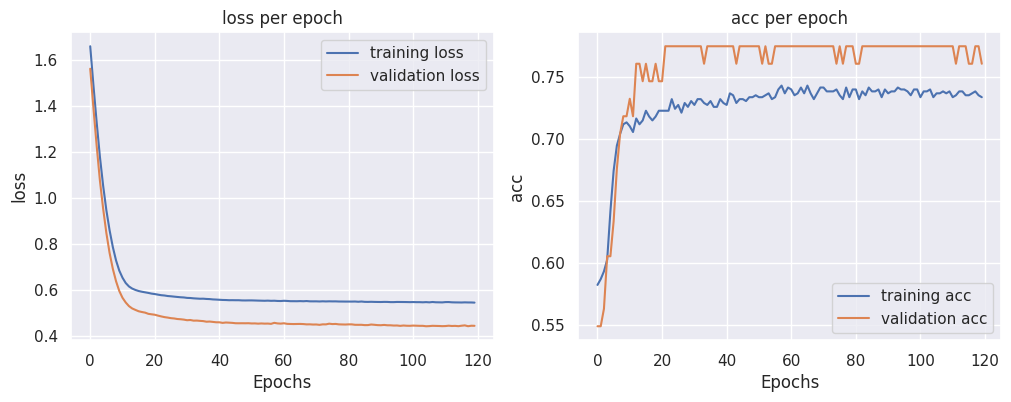

In [ ]:
mrmr_model = train_evaluate_k_fold(X_train_mrmr, y_train_mrmr, folds=10,
                                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)],
                                   inp_shape=X_train_mrmr.shape[-1],
                                   reshape=True,
                                   file_name="mrmr_learning_curves.png")

Precision score:  0.75
Recall score:  0.7636363636363637
F1 score:  0.7567567567567568
Accuracy score:  0.7857142857142857
ROC AUC:  0.7832266325224072


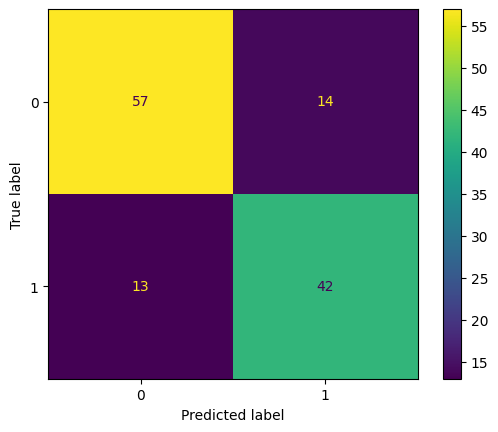

In [ ]:
evaluate_model(mrmr_model, X_test_mrmr, y_test_mrmr, True, True, confusion_file_name="mrmr_confusion.png");

GradWise

Since between the other two methods (lasso and mRMR) resulted in a higher performance in accuracy for the lasso, then the incrementing value for the LASSO method in the GradWise applications is set to two, while for the mRMR is set to 1. The whole GradWise method is explained in the [paper](https://www.semanticscholar.org/paper/GradWise%3A-A-Novel-Application-of-a-Rank-Based-and-Tasci-Jagasia/3d15f496d26236917196618cf775f970382f52c6) of the authors with more detail.

In [ ]:
def grad_wise(X, y, folds=10, **kwargs):
  """
  Following the rank-based approach proposed in the paper, the LASSO FS method
  had a better performance than mRMR. Hence, a value of 2 and 1 are assigned
  respectively.
  """
  kfold = KFold(n_splits=folds, shuffle=True)
  current_fold = 0
  alphas = np.linspace(0.0001, 0.0005, folds)
  lasso_algorithms = [Lasso(alpha=alphas[i]) for i in range(folds)]
  features_count = {f:0 for f in X.columns}
  for train, validation in kfold.split(X, y):
    print("_________________________________________________________________")
    print(f"Fold {current_fold}: ")
    # LASSO
    lasso_algorithms[current_fold].fit(X.iloc[train], y.iloc[train])
    lasso_coef = np.abs(lasso_algorithms[current_fold].coef_)
    sorted_indices = np.argsort(lasso_coef)[::-1]
    feature_subset_lasso = np.array(X.iloc[train].columns)[lasso_coef>-1]
    feature_subset_lasso = feature_subset_lasso[sorted_indices]
    feature_subset_lasso = feature_subset_lasso[:15]
    for feature in feature_subset_lasso:
      features_count[feature]+=2
    print(f"LASSO: {feature_subset_lasso}")
    # mRMR
    mrmr = mRMR(X.iloc[train], "MIQ", 15)
    mrmr = mrmr[:15]
    for feature in mrmr:
      features_count[feature]+=1
    print(f"mRMR: {mrmr}")
    current_fold+=1
  print("_________________________________________________________________")
  return features_count

In [ ]:
features_weights = grad_wise(X_train, y_train)

_________________________________________________________________
Fold 0: 
LASSO: ['IDH1' 'IDH2' 'NF1' 'GRIN2A' 'FAT4' 'EGFR' 'RB1' 'CSMD3' 'PTEN' 'PIK3R1'
 'TP53' 'NOTCH1' 'Age_at_diagnosis' 'SMARCA4' 'Race']
mRMR: ['Age_at_diagnosis', 'PIK3R1', 'CSMD3', 'FAT4', 'BCOR', 'NF1', 'IDH2', 'MUC16', 'PTEN', 'GRIN2A', 'ATRX', 'RB1', 'PDGFRA', 'Race', 'EGFR']
_________________________________________________________________
Fold 1: 
LASSO: ['IDH1' 'IDH2' 'NF1' 'GRIN2A' 'PTEN' 'RB1' 'PIK3R1' 'TP53' 'EGFR'
 'SMARCA4' 'NOTCH1' 'Age_at_diagnosis' 'MUC16' 'FAT4' 'CSMD3']
mRMR: ['Age_at_diagnosis', 'FAT4', 'BCOR', 'PIK3R1', 'CSMD3', 'IDH2', 'Race', 'ATRX', 'NOTCH1', 'NF1', 'PDGFRA', 'RB1', 'SMARCA4', 'GRIN2A', 'PTEN']
_________________________________________________________________
Fold 2: 
LASSO: ['IDH1' 'IDH2' 'NF1' 'PDGFRA' 'GRIN2A' 'PIK3R1' 'NOTCH1' 'TP53' 'EGFR'
 'PTEN' 'RB1' 'SMARCA4' 'Age_at_diagnosis' 'MUC16' 'CSMD3']
mRMR: ['Age_at_diagnosis', 'PIK3R1', 'BCOR', 'IDH2', 'FAT4', 'NF1', 'CIC

After the GradWise process is applied, all the features are sorted based on the weight obtained for each one of them, resulting in the table shown in the cell below

In [ ]:
features_count = pd.DataFrame(features_weights, index=[0])
features_count = features_count.transpose().sort_values(by=0, ascending=False)
features_count

,0
PTEN,30
Age_at_diagnosis,30
IDH2,30
PIK3R1,30
RB1,29
NF1,28
SMARCA4,27
GRIN2A,26
FAT4,24
EGFR,24


Then, because of the iterative nature of the method, a function is created in order to train a neural network with the minimum weight received as a parameter. The model is trained and returned along with the selected features set.

In [ ]:
def train_grad_wise(X_train, y_train, min_weight=30, **kwargs):
  selected_features = features_count.where(features_count>=min_weight).dropna().transpose().columns
  X_train = X_train[selected_features]
  print(f"Using minimum weight {min_weight}. Features: {selected_features.to_list()}")
  best_grad_wise_model = train_evaluate_k_fold(X_train, y_train,
                                               inp_shape=X_train.shape[-1],
                                               callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=15)],
                                               reshape=True, **kwargs)
  return best_grad_wise_model, selected_features

The training process the is performed using as minimum weights the values between 30 and 5 with diminishing steps of 5. So, the features are selected according to those that have a minimum weight of 30, then a minimum weight of 25 and so on.

Using minimum weight 30. Features: ['PTEN', 'Age_at_diagnosis', 'IDH2', 'PIK3R1']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_210 (Dense)           (None, None, 4)           20        
                                                                 
 dense_211 (Dense)           (None, None, 15)          75        
                                                                 
 dense_212 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 111 (444.00 Byte)
Trainable params: 111 (444.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7346471756906541, Average Recall: 0.6498548942097329, Average F1: 0.6848756706425003, Average Accuracy: 0.7587441314553991, Average ROC AUC: 0.7444003953897804
Best model: fold 4. Pre

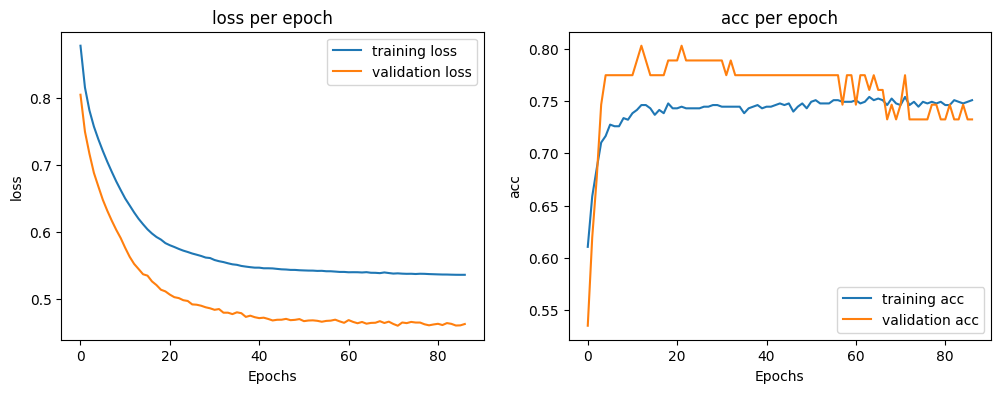

Precision score:  0.8372093023255814
Recall score:  0.6545454545454545
F1 score:  0.7346938775510204
Accuracy score:  0.7936507936507936
ROC AUC:  0.7779769526248399


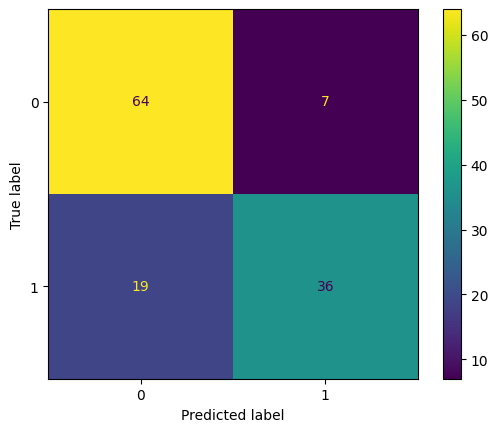

Using minimum weight 25. Features: ['PTEN', 'Age_at_diagnosis', 'IDH2', 'PIK3R1', 'RB1', 'NF1', 'SMARCA4', 'GRIN2A']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_240 (Dense)           (None, None, 8)           72        
                                                                 
 dense_241 (Dense)           (None, None, 15)          135       
                                                                 
 dense_242 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 223 (892.00 Byte)
Trainable params: 223 (892.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7533712536521113, Average Recall: 0.6719362223797708, Average F1: 0.7055262498371864, Average Accuracy: 0.7654538341158059, Average ROC AUC: 0.75274

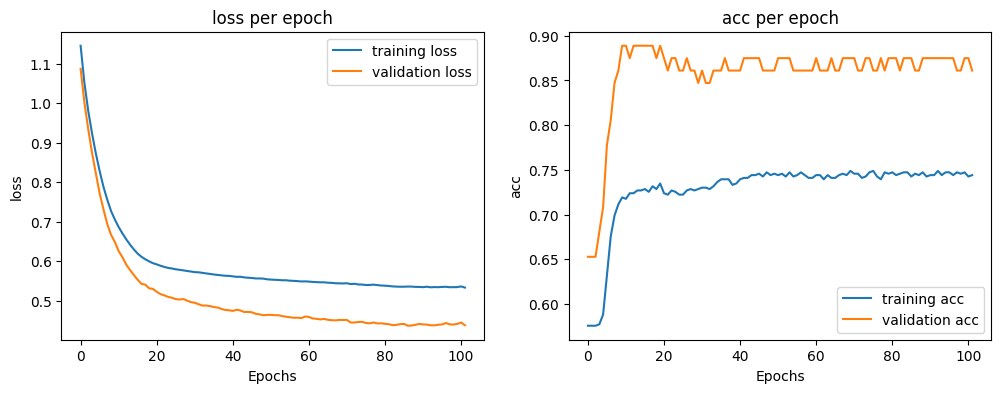

Precision score:  0.8409090909090909
Recall score:  0.6727272727272727
F1 score:  0.7474747474747475
Accuracy score:  0.8015873015873016
ROC AUC:  0.787067861715749


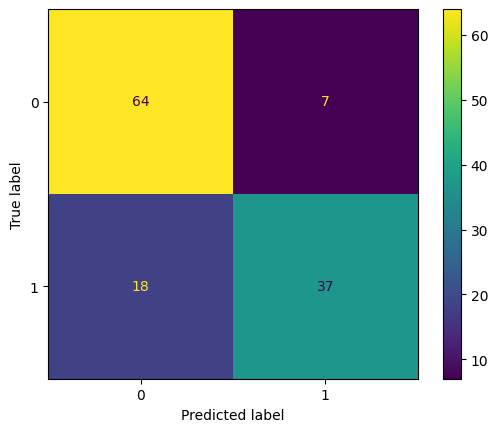

Using minimum weight 20. Features: ['PTEN', 'Age_at_diagnosis', 'IDH2', 'PIK3R1', 'RB1', 'NF1', 'SMARCA4', 'GRIN2A', 'FAT4', 'EGFR', 'NOTCH1', 'MUC16', 'TP53', 'IDH1']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_270 (Dense)           (None, None, 14)          210       
                                                                 
 dense_271 (Dense)           (None, None, 15)          225       
                                                                 
 dense_272 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 451 (1.76 KB)
Trainable params: 451 (1.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7985147969846246, Average Recall: 0.9093518261030777, Average F1: 0.8488835230301609, Average Accuracy: 0

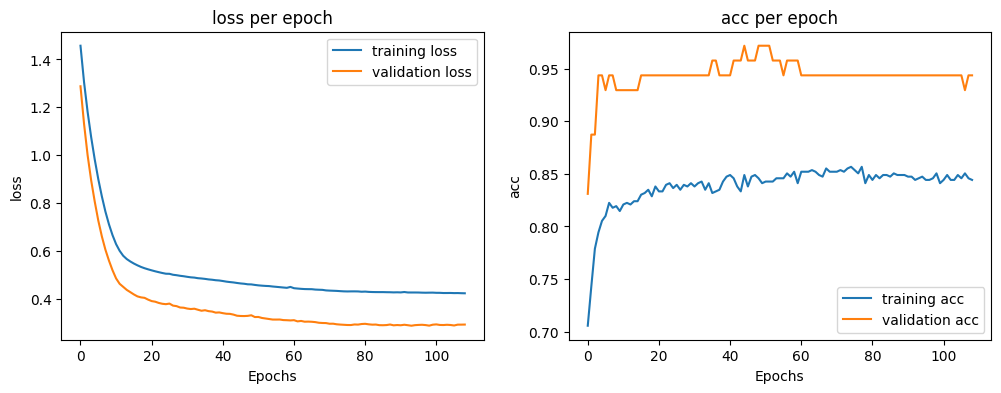

Precision score:  0.828125
Recall score:  0.9636363636363636
F1 score:  0.8907563025210083
Accuracy score:  0.8968253968253969
ROC AUC:  0.9043533930857874


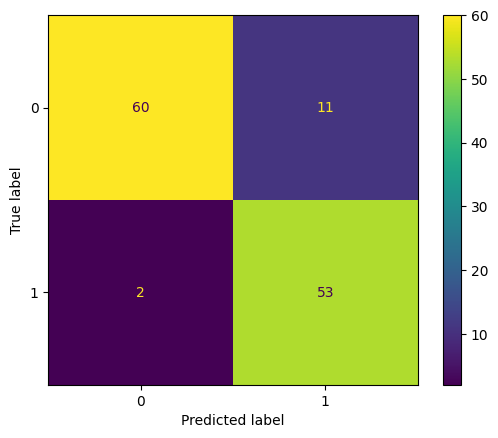

Using minimum weight 15. Features: ['PTEN', 'Age_at_diagnosis', 'IDH2', 'PIK3R1', 'RB1', 'NF1', 'SMARCA4', 'GRIN2A', 'FAT4', 'EGFR', 'NOTCH1', 'MUC16', 'TP53', 'IDH1', 'CSMD3', 'PDGFRA']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_300 (Dense)           (None, None, 16)          272       
                                                                 
 dense_301 (Dense)           (None, None, 15)          255       
                                                                 
 dense_302 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 543 (2.12 KB)
Trainable params: 543 (2.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7936171356704039, Average Recall: 0.9020548340548341, Average F1: 0.8436865156092642, 

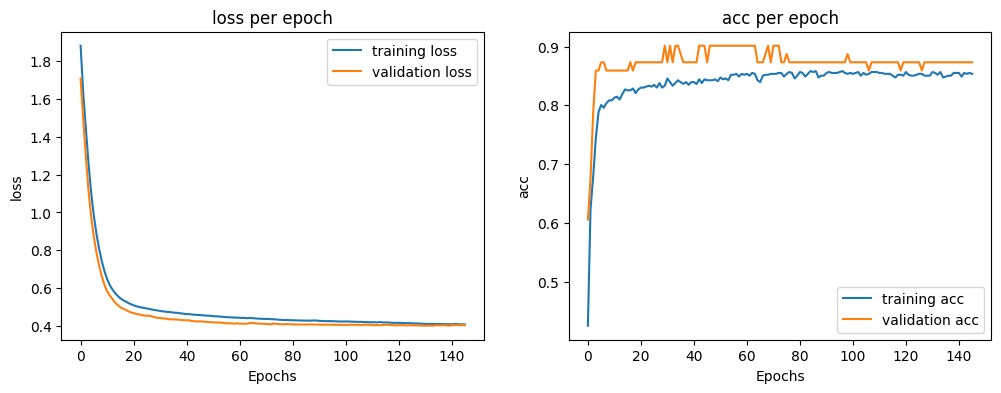

Precision score:  0.8253968253968254
Recall score:  0.9454545454545454
F1 score:  0.8813559322033897
Accuracy score:  0.8888888888888888
ROC AUC:  0.8952624839948783


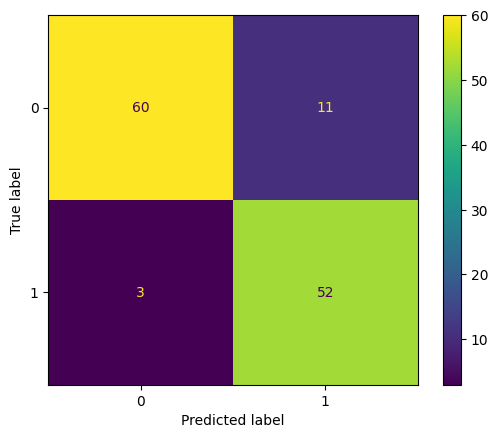

Using minimum weight 10. Features: ['PTEN', 'Age_at_diagnosis', 'IDH2', 'PIK3R1', 'RB1', 'NF1', 'SMARCA4', 'GRIN2A', 'FAT4', 'EGFR', 'NOTCH1', 'MUC16', 'TP53', 'IDH1', 'CSMD3', 'PDGFRA', 'ATRX', 'Race', 'BCOR', 'CIC']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_330 (Dense)           (None, None, 20)          420       
                                                                 
 dense_331 (Dense)           (None, None, 15)          315       
                                                                 
 dense_332 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 751 (2.93 KB)
Trainable params: 751 (2.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7926505819449368, Average Recall: 0.9050193565703853, A

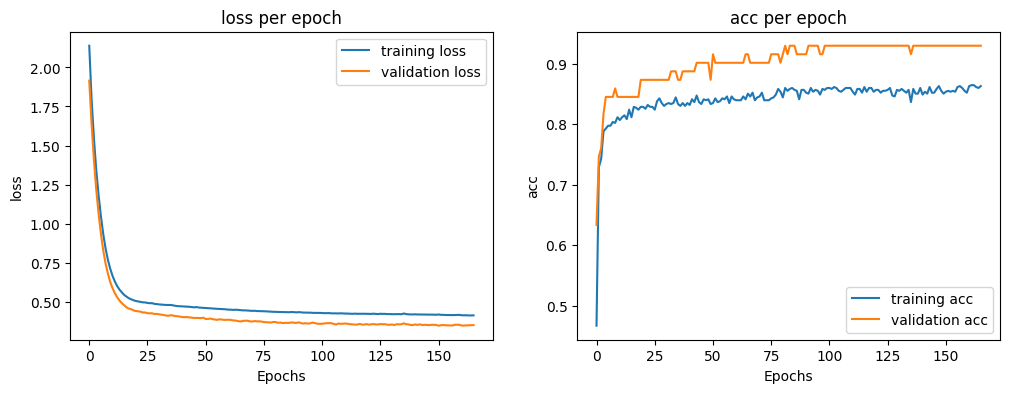

Precision score:  0.828125
Recall score:  0.9636363636363636
F1 score:  0.8907563025210083
Accuracy score:  0.8968253968253969
ROC AUC:  0.9043533930857874


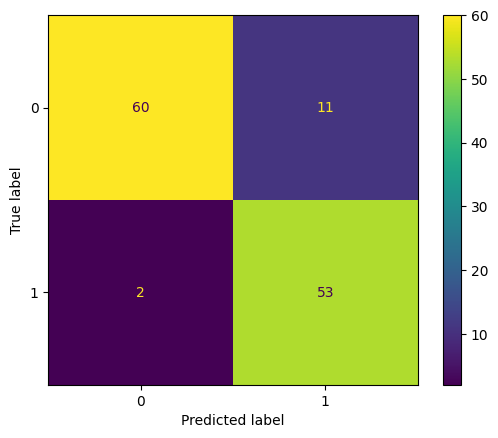

Using minimum weight 5. Features: ['PTEN', 'Age_at_diagnosis', 'IDH2', 'PIK3R1', 'RB1', 'NF1', 'SMARCA4', 'GRIN2A', 'FAT4', 'EGFR', 'NOTCH1', 'MUC16', 'TP53', 'IDH1', 'CSMD3', 'PDGFRA', 'ATRX', 'Race', 'BCOR', 'CIC', 'PIK3CA']
Model: "Fold-0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_360 (Dense)           (None, None, 21)          462       
                                                                 
 dense_361 (Dense)           (None, None, 15)          330       
                                                                 
 dense_362 (Dense)           (None, None, 1)           16        
                                                                 
Total params: 808 (3.16 KB)
Trainable params: 808 (3.16 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Average Precision: 0.7963706013117777, Average Recall: 0.9009814127

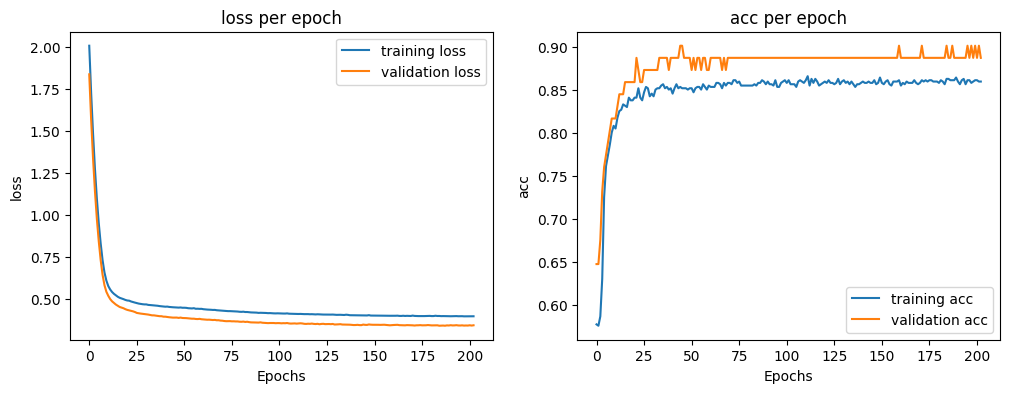

Precision score:  0.828125
Recall score:  0.9636363636363636
F1 score:  0.8907563025210083
Accuracy score:  0.8968253968253969
ROC AUC:  0.9043533930857874


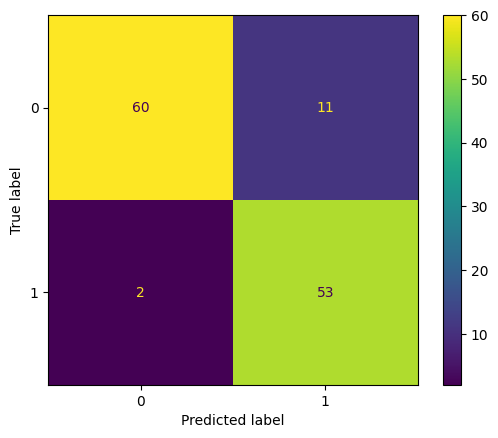

In [ ]:
# Training for all minimum weights
precision_grad_wise = list()
recall_grad_wise = list()
f1_grad_wise = list()
acc_grad_wise = list()
auc_grad_wise = list()
features = list()
models = list()
for i in range(30, 0, -5):
  best_grad_wise_model_i, selected_features_i = train_grad_wise(X_train, y_train, i, print_all_results=False, file_name=f"grad_wise_{i}_min_weight_learning.png")
  models.append(best_grad_wise_model_i)
  pres, rec, f1, acc, auc = evaluate_model(best_grad_wise_model_i, X_test[selected_features_i], y_test, reshape=True, plot_confusion_matrix=True, confusion_file_name=f"grad_{i}_weight_{selected_features_i.to_list()}_features_confusion.png");
  precision_grad_wise.append(pres)
  recall_grad_wise.append(rec)
  f1_grad_wise.append(f1)
  acc_grad_wise.append(acc)
  auc_grad_wise.append(auc)
  features.append(selected_features_i)
best_grad_model = models[np.argmax(np.array(acc_grad_wise))]

In [ ]:
results = {
    "minimum_weight": range(30, 0, -5),
    "number_of_features": list(map(lambda x: len(x), features)),
    "features": list(map(lambda x: x.to_list(), features)),
    "precision": precision_grad_wise,
    "recall": recall_grad_wise,
    "f1": f1_grad_wise,
    "accuracy": acc_grad_wise,
    "ROC AUC": auc_grad_wise
}

In [ ]:
grad_wise_metrics = pd.DataFrame().from_dict(results)
grad_wise_metrics.to_csv("grad_wise_metrics.csv")

The metrics obtained for each minimum weight is shown in the table below

In [ ]:
grad_wise_metrics

,minimum_weight,number_of_features,features,precision,recall,f1,accuracy,ROC AUC
0,30,4,"[PTEN, Age_at_diagnosis, IDH2, PIK3R1]",0.837209,0.654545,0.734694,0.793651,0.777977
1,25,8,"[PTEN, Age_at_diagnosis, IDH2, PIK3R1, RB1, NF...",0.840909,0.672727,0.747475,0.801587,0.787068
2,20,14,"[PTEN, Age_at_diagnosis, IDH2, PIK3R1, RB1, NF...",0.828125,0.963636,0.890756,0.896825,0.904353
3,15,16,"[PTEN, Age_at_diagnosis, IDH2, PIK3R1, RB1, NF...",0.825397,0.945455,0.881356,0.888889,0.895262
4,10,20,"[PTEN, Age_at_diagnosis, IDH2, PIK3R1, RB1, NF...",0.828125,0.963636,0.890756,0.896825,0.904353
5,5,21,"[PTEN, Age_at_diagnosis, IDH2, PIK3R1, RB1, NF...",0.828125,0.963636,0.890756,0.896825,0.904353


In [ ]:
fig = px.line(results, x="minimum_weight",
              y=["recall", "accuracy",  "f1", "precision", "ROC AUC"], labels={
                  "minimum_weight": "Minimum weight",
                  "value": "Value",
                  "variable": "Metrics"
              }, title="Metrics by Feature")
fig.show()